<a href="https://colab.research.google.com/github/AsiyatShch/Internship/blob/master/asiyat_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.2 MB/s eta 0:00:00


In [2]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00


In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib widget

In [7]:
import optuna

from sklearn import metrics
from sklearn import svm
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier

In [6]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')
output.enable_custom_widget_manager()

Mounted at /content/drive


# Data


In [8]:
def read_omg_csv(path_palm_data: str,
                 n_omg_channels: int,
                 n_acc_channels: int = 0,
                 n_gyr_channels: int = 0,
                 n_mag_channels: int = 0,
                 n_enc_channels: int = 0,
                 button_ch: bool = True,
                 sync_ch: bool = True,
                 timestamp_ch: bool = True) -> pd.DataFrame:

    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''

    df_raw = pd.read_csv(path_palm_data, sep=' ',
                         header=None,
                         skipfooter=1,
                         skiprows=1,
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()

    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'],
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]

    if button_ch:
        columns = columns + ['BUTTON']

    if sync_ch:
        columns = columns + ['SYNC']

    if timestamp_ch:
        columns = columns + ['ts']

    df_raw.columns = columns

    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

In [9]:
# We have 31 datasets
datasets = ['2023-04-18_19-08-47 gestures train.palm',
            '2023-05-05_17-57-30.palm',
            '2023-05-07_15-19-05.palm',
            '2023-05-31_17-14-41.palm',
            '2023-05-07_16-54-27.palm',
            '2023-05-12_19-17-00.palm',
            '2023-05-15_16-16-08.palm',
            '2023-05-15_17-12-24.palm',
            '2023-05-19_12-04-02.palm',
            '2023-05-22_17-04-29.palm',
            '2023-05-22_20-22-01.palm',
            '2023-05-31_15-46-37.palm',
            '2023-06-05_16-12-38.palm',
            '2023-06-05_17-53-01.palm',
            '2023-06-20_12-34-17.palm',
            '2023-06-20_13-30-15.palm',
            '2023-06-20_14-43-11.palm',
            '2023-09-12_12-55-22.palm',
            '2023-09-12_14-59-23.palm',
            '2023-09-13_22-14-05.palm',
            '2023-09-29_09-20-47.palm',
            '2023-09-29_11-03-50.palm',
            '2023-09-30_08-06-44.palm',
            '2023-10-18_08-05-29.palm',
            '2023-10-18_11-16-21.palm',
            '2023-10-23_10-11-45.palm',
            '2023-10-23_14-07-13.palm',
            '2023-10-23_16-23-02.palm',
            '2023-10-25_08-52-30.palm',
            '2023-10-25_11-08-46.palm',
            'patched_2023-10-25_09-44-02.palm'
            ]

We have 4 pilots for 31 datasets.

In [10]:
first_pilot = ['2023-05-15_16-16-08.palm',
         '2023-05-15_17-12-24.palm',
         '2023-06-05_16-12-38.palm',
         '2023-06-05_17-53-01.palm',
         '2023-06-20_12-34-17.palm',
         '2023-06-20_13-30-15.palm',
         '2023-06-20_14-43-11.palm']

print('First pilot datasets number:', len(first_pilot))

First pilot datasets number: 7


In [11]:
third_pilot = ['2023-05-07_16-54-27.palm',
         '2023-05-07_15-19-05.palm',
         '2023-05-12_19-17-00.palm',
         '2023-04-18_19-08-47 gestures train.palm'

]

print('Third pilot datasets number:', len(third_pilot))

Third pilot datasets number: 4


In [12]:
# Only one data set for the fourth pilot
fourth_pilot = ['2023-05-05_17-57-30.palm']

In [13]:
second_pilot = []

for i in datasets:
  if i not in (first_pilot + third_pilot + fourth_pilot):
    second_pilot.append(i)

print('Second pilot datasets number:', len(second_pilot))

Second pilot datasets number: 19


In [43]:
# Let's focus on one dataset
palm_file = fourth_pilot[0]
gestures = read_omg_csv(palm_file,
                              n_omg_channels=50,
                              n_acc_channels=3,
                              n_gyr_channels=3,
                              n_enc_channels=6,
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(26648, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,0,11,58,3462,3692,3417,1868,13,7,5,...,-1,0,0,0,0,0,0,0,0,161823
1,10,8,51,3463,3693,3418,1870,21,6,6,...,4,0,0,0,0,0,0,0,0,161856
2,11,9,58,3463,3692,3418,1871,13,6,6,...,6,0,0,0,0,0,0,0,0,161889
3,11,8,58,3460,3692,3418,1869,13,6,5,...,7,0,0,0,0,0,0,0,0,161922
4,24,8,58,3460,3691,3417,1856,13,7,12,...,8,0,0,0,0,0,0,0,0,161955


In [44]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


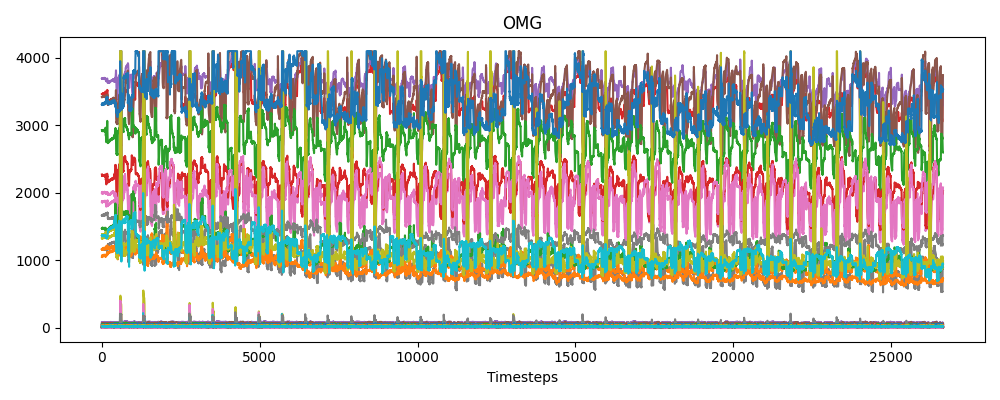

In [22]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

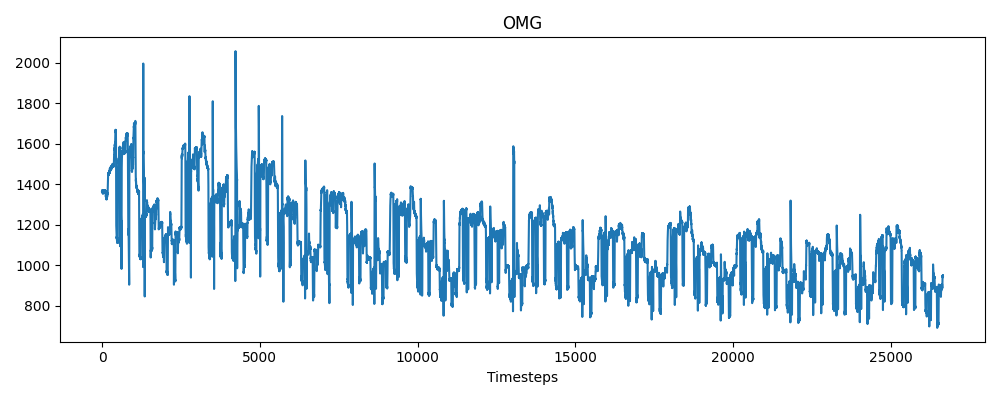

In [23]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures.iloc[:, 39].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [45]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [46]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [47]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [48]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])

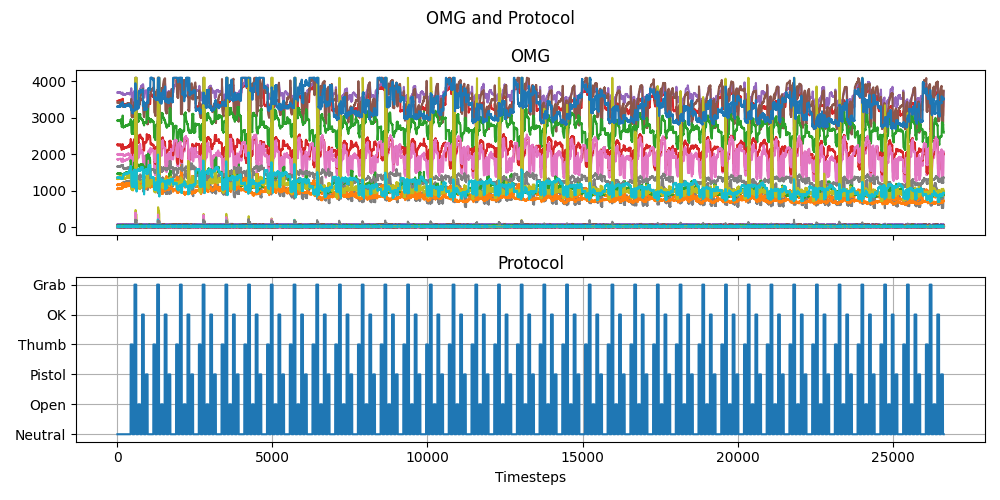

In [24]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

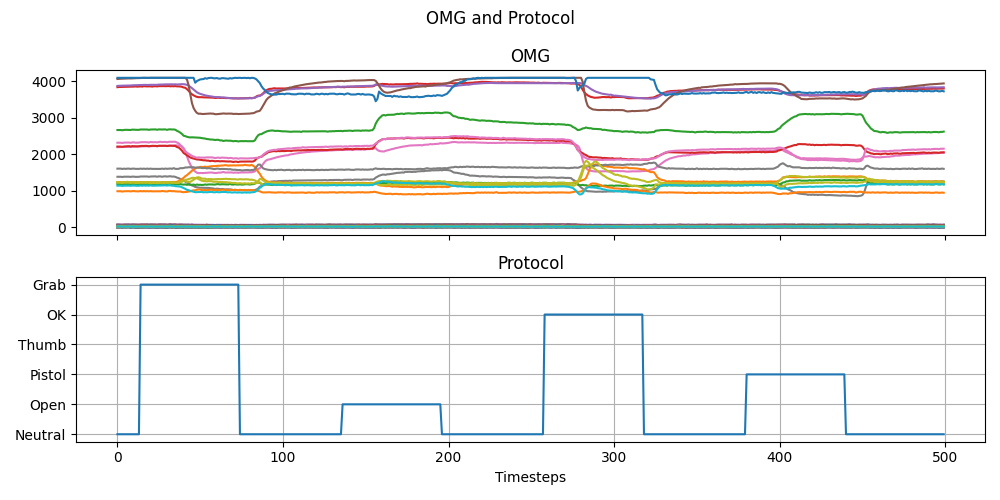

In [25]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].iloc[2000:2500, :].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd[2000:2500])
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [49]:
df_meta = pd.read_csv('meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [50]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

20756

#Preprocessing

In [51]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

## Feature importance

In [52]:
def optuna_dt(trial):
  max_depth = trial.suggest_int('max_depth', 10, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)


  model = tree.DecisionTreeClassifier(max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)

  model.fit(X_train, y_train)
  score = round(metrics.f1_score(y_test, model.predict(X_test), average='weighted'), 3)

  return score

In [ ]:
%%time

study = optuna.create_study(study_name="DecisionTreeClassifier", direction="maximize")

study.optimize(optuna_dt, n_trials=100)

In [ ]:
t_params = study.best_params

In [53]:
t_model = tree.DecisionTreeClassifier(**t_params, random_state=42)

t_model.fit(X_train, y_train)
t_model.predict(X_train)

importances = list(t_model.feature_importances_)
best_features = {}
i = 0

for col in gestures.columns:
  if len(importances) < i + 1:
    break
  best_features[col] = importances[i]
  i += 1

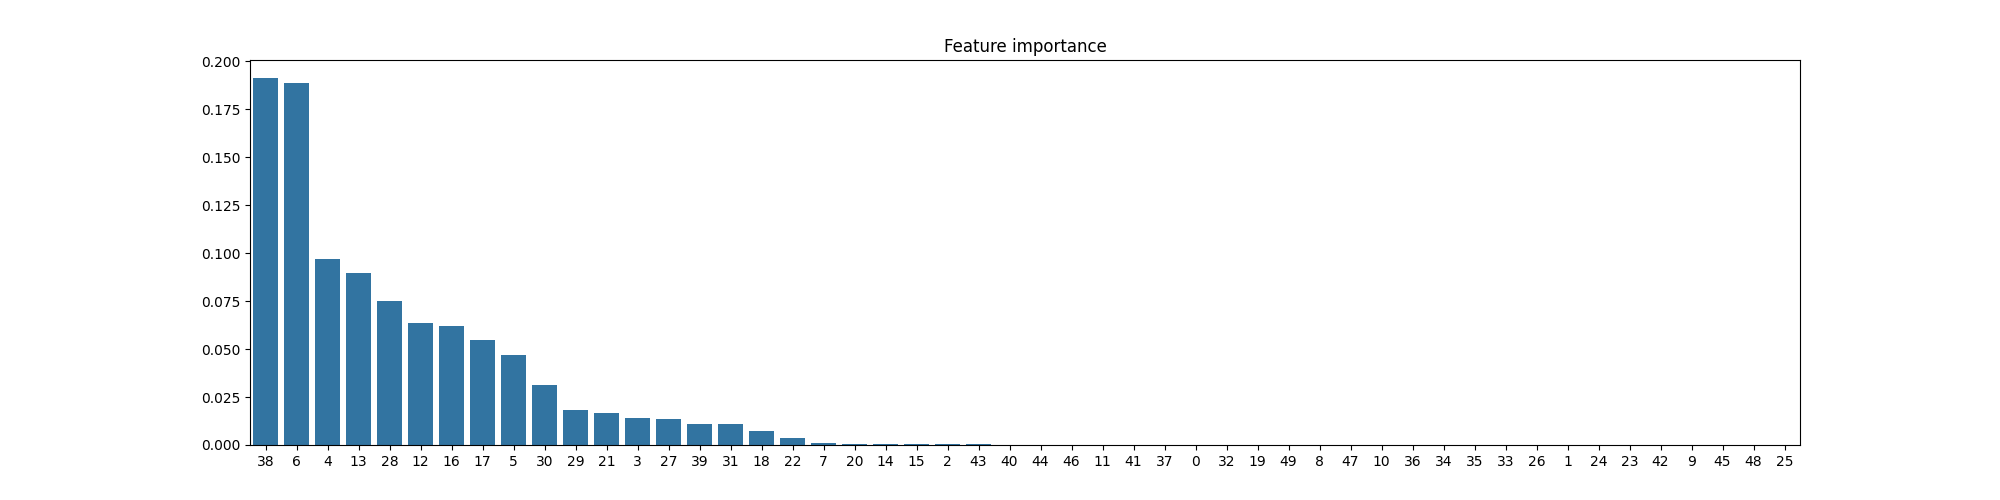

In [54]:
plt.figure(figsize=(20, 5))
sns.barplot(pd.Series(best_features).sort_values(ascending=False))

plt.title('Feature importance')
plt.show()

In [55]:
feature_mean = sum(importances) / len(importances)
best_list = []

for i in best_features:
  if best_features[i] > feature_mean:
    best_list.append(i)

print('Number of important features:', len(best_list))

Number of important features: 10


In [56]:
for i in range(len(best_list)):
  best_list[i] = int(best_list[i])
best_list

[4, 5, 6, 12, 13, 16, 17, 28, 30, 38]

In [57]:
X_train = X_train[:, best_list]
X_test = X_test[:, best_list]

## Smoothing

In [58]:
X_train_base = X_train
X_test_base = X_test

X_train_smoothed = pd.DataFrame(X_train).rolling(5, 1).sum()
X_test_smoothed = pd.DataFrame(X_test).rolling(5, 1).sum()

X_train = pd.DataFrame(X_train)
X_train = X_train_smoothed.join(X_train, rsuffix='sum')

X_test = pd.DataFrame(X_test)
X_test = X_test_smoothed.join(X_test, rsuffix='sum')

X_train_smoothed_again = pd.DataFrame(X_train_base).rolling(10, 1).sum()
X_test_smoothed_again = pd.DataFrame(X_test_base).rolling(10, 1).sum()

In [59]:
X_train = pd.DataFrame(X_train)
X_train = X_train_smoothed_again.join(X_train, rsuffix='sum_again')

X_test = pd.DataFrame(X_test)
X_test = X_test_smoothed_again.join(X_test, rsuffix='sum_again')

X_train_mean = pd.DataFrame(X_train_base).rolling(5, 1).mean()
X_test_mean = pd.DataFrame(X_test_base).rolling(5, 1).mean()

X_train = X_train.join(X_train_mean, rsuffix='mean')
X_test = X_test.join(X_test_mean, rsuffix='mean')

X_train_std = pd.DataFrame(X_train_base).rolling(5).std().fillna(0)
X_test_std = pd.DataFrame(X_test_base).rolling(5).std().fillna(0)

X_train = X_train.join(X_train_std, rsuffix='std')
X_test = X_test.join(X_test_std, rsuffix='std')

X_train_median = pd.DataFrame(X_train_base).rolling(5, 1).median()
X_test_median = pd.DataFrame(X_test_base).rolling(5, 1).median()

X_train = X_train.join(X_train_median, rsuffix='median')
X_test = X_test.join(X_test_median, rsuffix='median')

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

<ipython-input-59-a4cb7c3a09fe>:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'5', '9', '6', '2', '3', '4', '8', '0', '1', '7'} in the result is deprecated and will raise a MergeError in a future version.
  X_train = X_train.join(X_train_mean, rsuffix='mean')
<ipython-input-59-a4cb7c3a09fe>:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'5', '9', '6', '2', '3', '4', '8', '0', '1', '7'} in the result is deprecated and will raise a MergeError in a future version.
  X_test = X_test.join(X_test_mean, rsuffix='mean')
<ipython-input-59-a4cb7c3a09fe>:22: FutureWarning: Passing 'suffixes' which cause duplicate columns {'5', '9', '6', '2', '3', '4', '8', '0', '1', '7'} in the result is deprecated and will raise a MergeError in a future version.
  X_train = X_train.join(X_train_median, rsuffix='median')
<ipython-input-59-a4cb7c3a09fe>:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'5', '9', '6', '2', '3', '4', '8', '0', '1', '7'}

## Scaling

In [60]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

## SVM

In [61]:
clf = svm.SVC()
clf.fit(X_train, y_train)

y_pred_train_alt = clf.predict(X_train)
y_pred_test_alt = clf.predict(X_test)

print(classification_report(y_train, y_pred_train_alt, target_names=GESTURES))
print(classification_report(y_test, y_pred_test_alt, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.85      0.93      0.89     12287
        Open       0.87      0.79      0.83      1694
      Pistol       0.84      0.72      0.78      1696
       Thumb       0.88      0.76      0.81      1693
          OK       0.88      0.73      0.80      1692
        Grab       0.93      0.78      0.85      1694

    accuracy                           0.86     20756
   macro avg       0.88      0.78      0.83     20756
weighted avg       0.86      0.86      0.86     20756

              precision    recall  f1-score   support

     Neutral       0.84      0.93      0.88      3483
        Open       0.87      0.83      0.85       486
      Pistol       0.85      0.75      0.79       482
       Thumb       0.89      0.77      0.82       484
          OK       0.87      0.55      0.67       478
        Grab       0.88      0.77      0.82       479

    accuracy                           0.85      5892
   macro avg       0.87

In [62]:
clf = svm.SVC()
clf.fit(X_train, y_train)

metrics_train_dict = {}
metrics_test_dict = {}

def get_shift_right(y):

    for i in np.arange((len(y))-n):
        y[i] = y[i+n]
    return y

for n in range(1, 20):

    y_pred_train_alt_two = None
    y_pred_test_alt_two = None
    #y_pred_train_alt_two = pd.Series(y_pred_train_alt_change).shift(n, fill_value=0)
    #y_pred_test_alt_two = pd.Series(y_pred_test_alt_change).shift(n, fill_value=0)
    #y_pred_train_alt_two = get_shift_right(y_pred_train_alt_change)
    #y_pred_test_alt_two = get_shift_right(y_pred_test_alt_change)
    #metrics_train_dict[n] = metrics.f1_score(y_train, y_pred_train_alt_two, average='weighted')
    #metrics_test_dict[n] = metrics.f1_score(y_test, y_pred_test_alt_two, average='weighted')
    #metrics_train_dict[n] = metrics.f1_score(y_train, y_pred_train_alt_two, average='weighted')
    metrics_train_dict[n] = metrics.f1_score(y_train, get_shift_right(clf.predict(X_train)), average='weighted')
    metrics_test_dict[n] = metrics.f1_score(y_test, get_shift_right(clf.predict(X_test)), average='weighted')

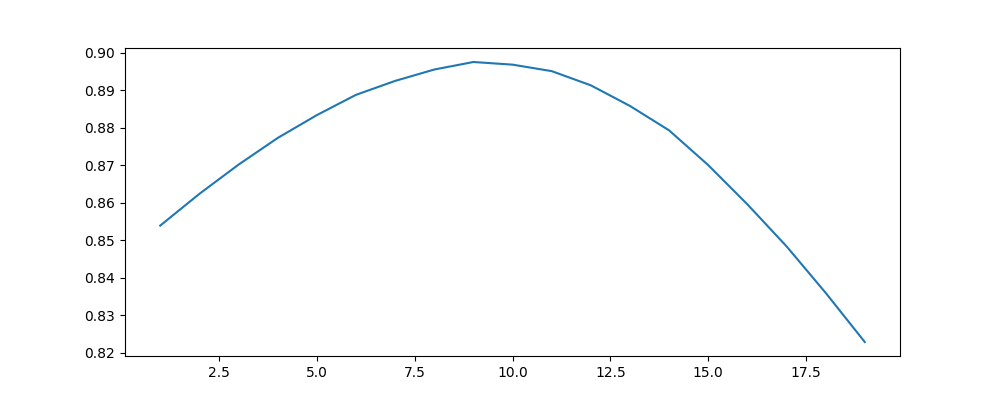

In [63]:
metrics_df = pd.Series(metrics_test_dict, index=metrics_test_dict.keys())
fig = plt.figure(figsize=(10, 4))
plt.plot(metrics_df);

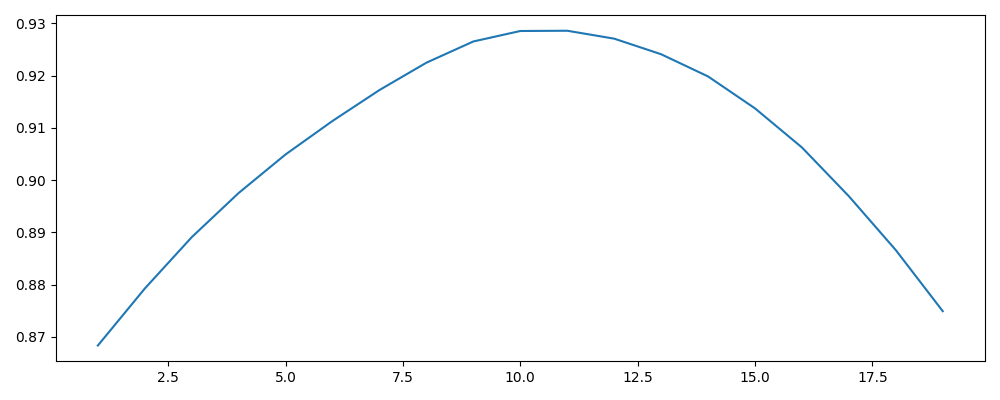

In [64]:
metrics_df_train = pd.Series(metrics_train_dict, index=metrics_train_dict.keys())
fig = plt.figure(figsize=(10, 4))
plt.plot(metrics_df_train)
plt.tight_layout();

In [65]:
def get_shift_right(y):

    for i in np.arange((len(y))-9):
        y[i] = y[i+9]
    return y

In [66]:
def optuna_svm(trial):
  # задаем пространства поиска гиперпараметров
  C = trial.suggest_float('C', 0.1, 7.0)

  # создаем модель
  model = svm.SVC(C=C)
  # обучаем модель
  model.fit(X_train, y_train)
  score = round(metrics.f1_score(y_test, get_shift_right(model.predict(X_test)), average='weighted'), 3)

  return score

In [67]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="SVM", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_svm, n_trials=20)

[I 2024-03-20 23:51:27,092] A new study created in memory with name: SVM
[I 2024-03-20 23:51:41,774] Trial 0 finished with value: 0.878 and parameters: {'C': 2.8505761570723247}. Best is trial 0 with value: 0.878.
[I 2024-03-20 23:51:55,911] Trial 1 finished with value: 0.859 and parameters: {'C': 4.58178974612721}. Best is trial 0 with value: 0.878.
[I 2024-03-20 23:52:16,840] Trial 2 finished with value: 0.899 and parameters: {'C': 0.5184418682907039}. Best is trial 2 with value: 0.899.
[I 2024-03-20 23:52:31,174] Trial 3 finished with value: 0.857 and parameters: {'C': 5.375415956280646}. Best is trial 2 with value: 0.899.
[I 2024-03-20 23:52:46,665] Trial 4 finished with value: 0.886 and parameters: {'C': 1.8942672767389261}. Best is trial 2 with value: 0.899.
[I 2024-03-20 23:53:01,845] Trial 5 finished with value: 0.873 and parameters: {'C': 3.280137557959355}. Best is trial 2 with value: 0.899.
[I 2024-03-20 23:53:16,404] Trial 6 finished with value: 0.857 and parameters: {'C': 

CPU times: user 5min 33s, sys: 1.83 s, total: 5min 35s
Wall time: 5min 45s


In [68]:
svm_best = study.best_params
print('Best params:', study.best_params)

Best params: {'C': 0.29954163317424}


In [70]:
clf = svm.SVC(**svm_best)
clf.fit(X_train, y_train)
y_pred_train_alt = clf.predict(X_train)
y_pred_test_alt = clf.predict(X_test)


y_pred_train_alt_three = get_shift_right(y_pred_train_alt)
y_pred_test_alt_three = get_shift_right(y_pred_test_alt)

print(classification_report(y_train, y_pred_train_alt_three, target_names=GESTURES))
print(classification_report(y_test, y_pred_test_alt_three, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.90      0.99      0.94     12287
        Open       0.96      0.89      0.92      1694
      Pistol       0.97      0.83      0.89      1696
       Thumb       0.98      0.84      0.91      1693
          OK       0.99      0.77      0.87      1692
        Grab       0.97      0.81      0.88      1694

    accuracy                           0.92     20756
   macro avg       0.96      0.86      0.90     20756
weighted avg       0.93      0.92      0.92     20756

              precision    recall  f1-score   support

     Neutral       0.88      0.99      0.93      3483
        Open       0.96      0.94      0.95       486
      Pistol       0.97      0.84      0.90       482
       Thumb       0.92      0.86      0.89       484
          OK       1.00      0.48      0.65       478
        Grab       0.96      0.86      0.91       479

    accuracy                           0.91      5892
   macro avg       0.95

# Real-time inference

In [ ]:
import time
import serial
from IPython.display import clear_output

ModuleNotFoundError: No module named 'serial'

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];

def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):

    X_test = scaler.fit_transform(X_test)
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],

    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:

    # [Data reading]
    ts_start = time.time()

    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]

    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


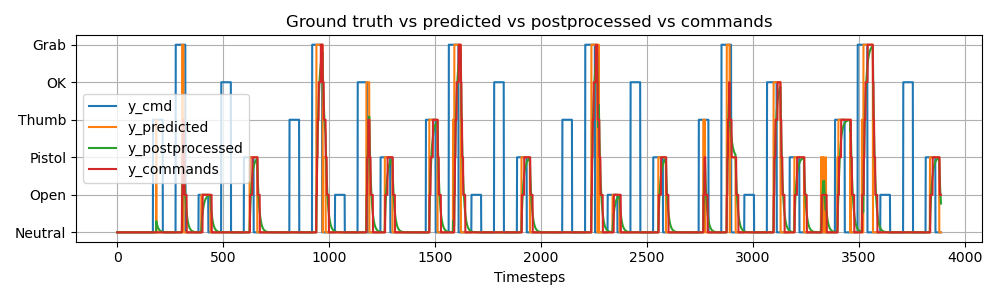

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()

    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()

i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:

    # [Data reading]
    s = ser.readline()
    ts_start = time.time()

    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])

    except Exception as e:
        print(e)

    # [/Data Reading]

    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]

    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]

    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]

    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]

    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]

    y_previous = y_postprocessed

    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)

    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1